<a href="https://colab.research.google.com/github/manassanant132/Fundamental-of-Deep-Learning/blob/main/Unit16_A_Book_Recommendation_Example_Collaborative_Filtering_using_Autoencoder_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collaborative Filtering เป็นเทคนิคหนึ่งที่ใช้ในการทำ Recommendation โดยอาศัยข้อมูลความพึงพอใจของ User ที่มีต่อ Item ต่างๆ อย่างเช่น การให้คะแนนความชอบในหนังสือแต่ละเล่ม การ Comment ภาพยนตร์แต่ละเรื่อง หรือการกด Like เพลงแต่ละเพลง เพื่อหาค่าความคล้ายคลึงของ User  (Similar Users) โดยระบบจะแนะนำ Item (หนังสือ ภาพยนตร์ หรือเพลง ฯลฯ) แบบที่ User คนหนึ่งชื่นชอบ แก่ User อีกคนที่มีความคล้ายคลึงกัน

อย่างไรก็ตาม สิ่งสำคัญประการหนึ่งที่จะทำให้การทำ Recommendation ด้วยเทคนิค Collaborative Filtering ประสบความสำเร็จ คือ จะต้องมีจำนวน User ที่มีปฏิสัมพัน (Rating, Comment, กด Like ฯลฯ) กับ Item ต่างๆ ที่มากพอ

ในบทความนี้ผู้เขียนจะยกตัวอย่างการทำ Book Recommendation โดยใช้ข้อมูลการให้คะแนนหนังสือจาก Book-Crossing Dataset ซึ่งมีการแยกเก็บข้อมูล User, Book และ Book Ratings เป็นไฟล์ *.csv ทั้งหมด 3 ไฟล์ และใช้ Autoencoder Model เพื่อเรียนรู้ และทำนายคะแนนความชื่นชอบในหนังสือแต่ละเล่ม เพื่อจะแนะนำหนังสือที่มีคะแนนสูงสุด 10 อันดับให้แก่ User แต่ละคน

#Data Preparation

##Filter Data with Threshold

นอกจากจะต้องมีจำนวน User ที่มีการให้คะแนนหนังสือที่มากพอสำหรับการ Train Model แล้ว หนังสือแต่ละเล่มจะต้องมี User มา Review เป็นจำนวนหนึ่ง เพื่อให้ระบบสามารถแนะนำหนังสือได้ตรงกับความต้องการของ User มากที่สุด ซึ่งในการทดลอง เราจะกำหนดค่า Threshold เพื่อคัดกรองข้อมูลก่อนจะ Train Model ดังนี้

User แต่ละคนจะต้องมีการให้คะแนนหนังสือไม่น้อยกว่า 20 ครั้ง

หนังสือแต่ละเล่มจะต้องมี User มา Review ไม่น้อยกว่า 20 ครั้ง

หลักๆ ผู้เขียนจะใช้ภาษา SQL ร่วมกับ Pandas ในการ Query และ Tranform คะแนนการ Review หนังสือของ User แต่ละคนไปเป็น Matrix ขนาด M x N โดย M คือ จำนวน User และ N คือ จำนวนหนังสือ

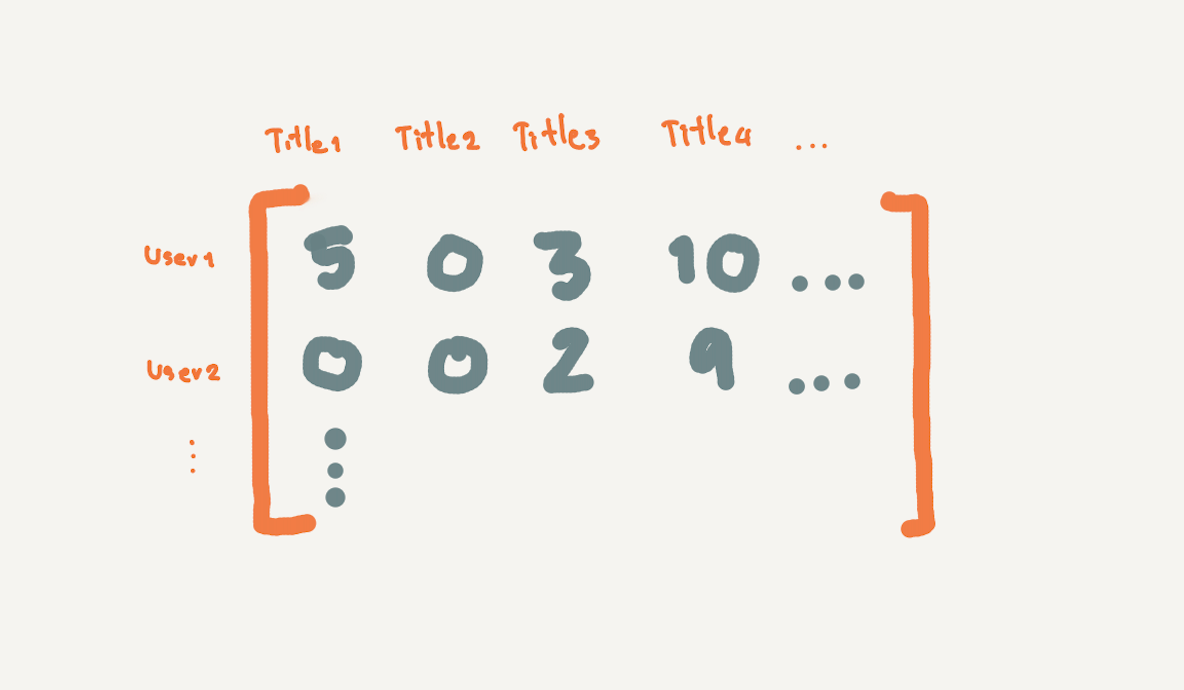

โดยมีขั้นตอนในการเตรียมข้อมูล ดังนี้

1) ติดตั้ง Library ที่จำเป็น

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf

ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
load_model = tf.keras.models.load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sqlite3

import plotly.express as px
import plotly
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')


2) Read CSV File

อ่านข้อมูล Book Ratings, User และ Book จากไฟล์ *.csv โดยกำหนดการเข้ารหัสแบบ "latin-1" ซึ่งคะแนนของ User จะมีค่าในช่วงตั้งแต่ 0 จนถึง 10



In [ ]:
from google.colab import drive

# To mount at google drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
rating = pd.read_csv('/content/drive/MyDrive/pjjop_csv/BX-Book-Ratings.csv', sep=';', encoding="latin-1")

print(rating.shape)
rating.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
user = pd.read_csv('/content/drive/MyDrive/pjjop_csv/BX-Users.csv', sep=';', encoding="latin-1")

print(user.shape)
user.head()

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
book = pd.read_csv('/content/drive/MyDrive/pjjop_csv/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")

print(book.shape)
book.head()

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


3) Connect SQLite Database Engine เพื่อสร้าง Table ใหม่

Connect และสร้าง SQLite Database ขึ้นมาใหม่ โดยบันทึกข้อมูลลงในไฟล์ "book_rec.db"

In [ ]:
connect = sqlite3.connect('book_rec.db')
connect

4) สร้าง Table book, user และ rating ใน SQLite Database ด้วยการ Import ข้อมูลจาก Dataframe

In [ ]:
book.to_sql("book", connect, if_exists='fail')
user.to_sql("user", connect, if_exists='fail')
rating.to_sql("rating", connect, if_exists='fail')

1149780

5) ติดตั้ง และ Load ipython-sql Library เพื่อจัดการ SQLite Database ด้วย Magic Command

ติดตั้ง ipython-sql ด้วยคำสั่ง pip install

In [ ]:
pip install ipython-sql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00


Load ipython-sql

In [ ]:
%load_ext sql

6) Connect SQLite Database Engine เพื่อจัดการกับ Database ด้วย Magic Command

In [ ]:
%sql sqlite:///book_rec.db

7) Check ข้อมูลใน Table rating, book และ user

In [ ]:
%sql SELECT * FROM rating LIMIT 5

 * sqlite:///book_rec.db
Done.


index,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
%sql SELECT * FROM book LIMIT 5

 * sqlite:///book_rec.db
Done.


index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [ ]:
%sql SELECT * FROM user LIMIT 5

 * sqlite:///book_rec.db
Done.


index,User-ID,Location,Age
0,1,"nyc, new york, usa",None
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",None
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",None


8) Merge Table rating กับ Table book

rating เป็น Table ที่จะนำข้อมูลไปแปลงเป็น Matrix เพื่อ Train Model โดยเราต้องการสร้าง Book Title เป็นอีกหนึ่ง Attribute ของ Table rating_book นอกเหนือจาก Attribute จาก Table rating ดังนั้นจึงต้องมีการ Joint Table rating กับ Table book ด้วย Attribute ISBN แบบ INNER JOIN ซึ่งเราไม่ต้องการให้ Attribute Book Title ใหม่ มีค่าเป็น Null เพราะไม่มีหมายเลข ISBN ใน Table book

In [ ]:
%%sql
CREATE TABLE rating_book AS SELECT rating."User-ID" AS UserID , rating.ISBN, rating."Book-Rating" AS BookRating, book."Book-Title" AS BookTitle
FROM rating
INNER JOIN book
ON rating.ISBN = book.ISBN

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table rating_book

In [ ]:
%%sql
SELECT * FROM rating_book LIMIT 5

 * sqlite:///book_rec.db
Done.


UserID,ISBN,BookRating,BookTitle
276725,034545104X,0,Flesh Tones: A Novel
276726,0155061224,5,Rites of Passage
276727,0446520802,0,The Notebook
276729,052165615X,3,Help!: Level 1
276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers)


ซึ่งพบว่า Table rating_book จะมีจำนวน Record ทั้งหมด 1,031,136 Record

In [ ]:
%%sql
SELECT count(*) FROM rating_book

 * sqlite:///book_rec.db
Done.


count(*)
1031136


9) นับจำนวนครั้งที่หนังสือแต่ละเล่มถูกให้คะแนน

เพื่อจะคัดกรองเฉพาะหนังสือที่มี User มา Review ไม่น้อยกว่า 20 ครั้ง เราจึงต้องนับจำนวนครั้งที่หนังสือแต่ละเล่มจะถูก Review ด้วยคำสั่ง GROUP BY โดยจะบันทึกข้อมูลการนับลงใน Table rating_count

In [ ]:
%%sql
CREATE TABLE rating_count AS SELECT "BookTitle", count(*) as RatingCountBook FROM rating_book GROUP BY "BookTitle"

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table rating_count

In [ ]:
%%sql
SELECT * from rating_count limit 5

 * sqlite:///book_rec.db
Done.


BookTitle,RatingCountBook
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",4
Always Have Popsicles,1
Apple Magic (The Collector's series),1
"Ask Lily (Young Women of Faith: Lily Series, Book 5)",1
Beyond IBM: Leadership Marketing and Finance for the 1990s,1


ซึ่งพบว่า Table rating_count จะมีจำนวน Record ทั้งหมด 241,071 Record

In [ ]:
%%sql
SELECT count(*) FROM rating_count

 * sqlite:///book_rec.db
Done.


count(*)
241071


10) คัดกรองหนังสือที่มี User มา Review ไม่น้อยกว่า 20 ครั้ง และบันทึกข้อมูลลงใน Table rating_count_filter

In [ ]:
rating_coun_threshold = 20

In [ ]:
%%sql
CREATE TABLE rating_count_filter AS SELECT * FROM rating_count WHERE RatingCountBook >= :rating_coun_threshold

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table rating_count_filter

In [ ]:
%%sql
SELECT * FROM rating_count_filter LIMIT 5

 * sqlite:///book_rec.db
Done.


BookTitle,RatingCountBook
'Salem's Lot,47
01-01-00: The Novel of the Millennium,22
10 Lb. Penalty,61
1001 Ways to Be Romantic,23
101 Dalmatians,37


ซึ่งพบว่า Table rating_count_filter จะมีจำนวน Record ทั้งหมด 7,608 Record

In [ ]:
%%sql
SELECT count(*) FROM rating_count_filter

 * sqlite:///book_rec.db
Done.


count(*)
7608


11) เลือกข้อมูลการ Review ของ User ในตาราง rating_book เฉพาะหนังสือที่มี User มา Review ไม่น้อยกว่า 20 ครั้ง และบันทึกข้อมูลลงใน Table user_rating และเพิ่ม RattingCountBook ของหนังสือเป็น Attribute หนึ่งใน Table user_rating ด้วย

In [ ]:
%%sql
CREATE TABLE user_rating AS SELECT rating_book.UserID, rating_book.ISBN, rating_book.BookRating, rating_book.BookTitle, rating_count_filter.RatingCountBook
FROM rating_count_filter
LEFT JOIN rating_book
ON rating_count_filter.BookTitle = rating_book.BookTitle

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table user_rating

In [ ]:
%%sql
SELECT * FROM user_rating LIMIT 5

 * sqlite:///book_rec.db
Done.


UserID,ISBN,BookRating,BookTitle,RatingCountBook
8936,067103975X,0,'Salem's Lot,47
9226,0451168089,0,'Salem's Lot,47
33283,0451168089,10,'Salem's Lot,47
35859,0385007515,9,'Salem's Lot,47
37950,0451168089,0,'Salem's Lot,47


ซึ่งพบว่า Table user_rating จะมีจำนวน Record ทั้งหมด 442,253 Record

In [ ]:
%%sql
SELECT count(*) FROM user_rating

 * sqlite:///book_rec.db
Done.


count(*)
442253


12) นับจำนวนครั้งในการ Review หนังสือของ User ใน Table user_rating และบันทึกข้อมูลลงใน Table user_count

In [ ]:
%%sql
CREATE TABLE user_count AS SELECT UserID, count(*) as RatingCountUser FROM user_rating GROUP BY UserID

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table user_count

In [ ]:
%%sql
SELECT * FROM user_count LIMIT 5

 * sqlite:///book_rec.db
Done.


UserID,RatingCountUser
8,3
9,2
10,1
14,1
16,2


ซึ่งพบว่า Table user_count จะมีจำนวน Record ทั้งหมด 60,046 Record

In [ ]:
%%sql
SELECT count(*) FROM user_count

 * sqlite:///book_rec.db
Done.


count(*)
60046


13) คัดกรอง User ที่ Review หนังสือ ไม่น้อยกว่า 20 ครั้ง และบันทึกข้อมูลลงใน Table user_count_filter

In [ ]:
user_count_filter_threshold = 20

In [ ]:
%%sql
CREATE TABLE user_count_filter AS SELECT * FROM user_count WHERE RatingCountUser >= :user_count_filter_threshold

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table user_count_filter

In [ ]:
%%sql
SELECT * FROM user_count_filter LIMIT 5

 * sqlite:///book_rec.db
Done.


UserID,RatingCountUser
243,70
254,148
487,21
507,71
638,54


ซึ่งพบว่า Table user_count_filter จะมีจำนวน Record ทั้งหมด 3,426 Record

In [ ]:
%%sql
SELECT count(*) FROM user_count_filter

 * sqlite:///book_rec.db
Done.


count(*)
3426


14) เลือกข้อมูลการ Review ของ User ในตาราง user_rating เฉพาะของ User ที่ Review หนังสือ ไม่น้อยกว่า 20 ครั้ง และบันทึกข้อมูลลงใน Table combined และเพิ่ม Table user_rating เป็น Attribute หนึ่งใน Table combined ด้วย

In [ ]:
%%sql
CREATE TABLE combined AS SELECT user_rating.BookTitle, user_rating.RatingCountBook, user_rating.UserID, user_rating.ISBN, user_rating.BookRating, user_count_filter.RatingCountUser
FROM user_rating
INNER JOIN user_count_filter
ON user_rating.UserID = user_count_filter.UserID

 * sqlite:///book_rec.db
Done.


[]

Check ข้อมูลใน Table combined

In [ ]:
%%sql
SELECT * FROM combined LIMIT 5

 * sqlite:///book_rec.db
Done.


BookTitle,RatingCountBook,UserID,ISBN,BookRating,RatingCountUser
'Salem's Lot,47,8936,067103975X,0,187
'Salem's Lot,47,33283,0451168089,10,20
'Salem's Lot,47,35859,0385007515,9,1843
'Salem's Lot,47,37950,0451168089,0,343
'Salem's Lot,47,48579,0385007515,0,57


ซึ่งพบว่า Table combined จะมีจำนวน Record ทั้งหมด 293,796 Record

In [ ]:
%%sql
SELECT count(*) FROM combined

 * sqlite:///book_rec.db
Done.


count(*)
293796


เมื่อคัดกรองข้อมูลการ Review ของ User ตามค่า Threshold ที่กำหนด ซึ่ง User แต่ละคนจะต้องมีการให้คะแนนหนังสือไม่น้อยกว่า 20 ครั้ง และหนังสือแต่ละเล่มจะต้องมี User มา Review ไม่น้อยกว่า 20 ครั้ง พบว่าข้อมูลที่คัดกรองแล้วมาจากหนังสือทั้งหมด 7,602 เล่ม และการ Review ของ User ทั้งหมด 3,426 คน

In [ ]:
%%sql
select count(distinct BookTitle) AS NumberOfUniqueBooks
FROM combined

 * sqlite:///book_rec.db
Done.


NumberOfUniqueBooks
7602


In [ ]:
%%sql
select count(distinct UserID) AS NumberOfUniqueUsers
FROM combined

 * sqlite:///book_rec.db
Done.


NumberOfUniqueUsers
3426


##Transform to Dataset

1) Export Table combined ไปยัง Dataframe

เพื่อจะสร้าง Matrix ของคะแนนการ Review หนังสือของ User สำหรับ Train Model เราจะ Export Table combined จาก SQLite Database ไปยัง Dataframe

In [ ]:
combined = %sql SELECT * FROM combined

 * sqlite:///book_rec.db
Done.


In [ ]:
combined_df = pd.DataFrame(data = combined, columns = combined.field_names)

combined_df.head()

,BookTitle,RatingCountBook,UserID,ISBN,BookRating,RatingCountUser
0,'Salem's Lot,47,8936,067103975X,0,187
1,'Salem's Lot,47,33283,0451168089,10,20
2,'Salem's Lot,47,35859,0385007515,9,1843
3,'Salem's Lot,47,37950,0451168089,0,343
4,'Salem's Lot,47,48579,0385007515,0,57


2) แปลงคะแนนจากเลขจำนวนเต็มเป็นเลขทศนิยม เพื่อจะทำ Normalization

In [ ]:
combined_df['BookRating'] = combined_df['BookRating'].values.astype(float)

print(combined_df.shape)
combined_df.head()

(293796, 6)


,BookTitle,RatingCountBook,UserID,ISBN,BookRating,RatingCountUser
0,'Salem's Lot,47,8936,067103975X,0.0,187
1,'Salem's Lot,47,33283,0451168089,10.0,20
2,'Salem's Lot,47,35859,0385007515,9.0,1843
3,'Salem's Lot,47,37950,0451168089,0.0,343
4,'Salem's Lot,47,48579,0385007515,0.0,57


3) Drop ข้อมูลที่มี UserID และ BookTitle ซ้ำกัน

In [ ]:
combined_df = combined_df.drop_duplicates(['UserID', 'BookTitle'])

print(combined_df.shape)

(289865, 6)


4) เปลื่ยนโครงสร้างข้ออมูลแบบ Table เป็น Matrix ด้วยฟังก์ชัน pivot

In [ ]:
user_book_matrix = combined_df.pivot(index='UserID', columns='BookTitle', values='BookRating')

print(user_book_matrix.shape)
user_book_matrix.head()

(3426, 7602)


BookTitle,'Salem's Lot,01-01-00: The Novel of the Millennium,10 Lb. Penalty,1001 Ways to Be Romantic,101 Dalmatians,"14,000 Things to Be Happy About",16 Lighthouse Road,1916: A Novel of the Irish Rebellion (Irish Century),1984,1st to Die: A Novel,...,Zombies of the Gene Pool,Zoya,ZwÃ?Â¶lf.,"\ Lamb to the Slaughter and Other Stories (Penguin 60s S.)""","\A\"" is for Alibi : A Kinsey Millhone Mystery (A Kinsey Millhone Mystery)""","\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",e,one hundred years of solitude,stardust
UserID,,,,,,,,,,,,,,,,,,,,,
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5) แทนที่ NaN ด้วย 0

In [ ]:
user_book_matrix.fillna(0, inplace=True)

user_book_matrix.head()

BookTitle,'Salem's Lot,01-01-00: The Novel of the Millennium,10 Lb. Penalty,1001 Ways to Be Romantic,101 Dalmatians,"14,000 Things to Be Happy About",16 Lighthouse Road,1916: A Novel of the Irish Rebellion (Irish Century),1984,1st to Die: A Novel,...,Zombies of the Gene Pool,Zoya,ZwÃ?Â¶lf.,"\ Lamb to the Slaughter and Other Stories (Penguin 60s S.)""","\A\"" is for Alibi : A Kinsey Millhone Mystery (A Kinsey Millhone Mystery)""","\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",e,one hundred years of solitude,stardust
UserID,,,,,,,,,,,,,,,,,,,,,
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


6) เก็บ UserID และ BookTitle ลง List

In [ ]:
users = user_book_matrix.index.tolist()

users[0:10]

[243, 254, 487, 507, 638, 741, 805, 882, 929, 1131]

In [ ]:
books = user_book_matrix.columns.tolist()

books[0:10]

["'Salem's Lot",
 '01-01-00: The Novel of the Millennium',
 '10 Lb. Penalty',
 '1001 Ways to Be Romantic',
 '101 Dalmatians',
 '14,000 Things to Be Happy About',
 '16 Lighthouse Road',
 '1916: A Novel of the Irish Rebellion (Irish Century)',
 '1984',
 '1st to Die: A Novel']

7) แปลง Matrix ที่อยู่ในรูป Dataframe เป็น Numpy Array

In [ ]:
user_book_matrix = user_book_matrix.to_numpy()

user_book_matrix.shape

(3426, 7602)

8) สุ่มแบ่งข้อมูลสำหรับการ Train 80% และสำหรับการ Validate 20%

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(user_book_matrix, user_book_matrix, test_size=0.2, random_state=1)

9) ทำ Normalization

In [ ]:
t = MinMaxScaler()

t.fit(user_book_matrix)
x_train = t.transform(x_train)
x_val = t.transform(x_val)

In [ ]:
print(x_train.min(), x_train.max())
print(x_val.min(), x_val.max())

0.0 1.0
0.0 1.0


คะแนนของ User จะมีค่าในช่วงตั้งแต่ 0.0 จนถึง 1.0

#Autoencoder Model

Autoencoder เป็น Neural Network ที่มีโครงสร้างคล้ายรูปนาฬิกาทราย ซึ่งส่วนปลายทั้งสองข้างกว้าง แต่ตรงกลางของ Model แคบ ดังภาพด้านล่าง

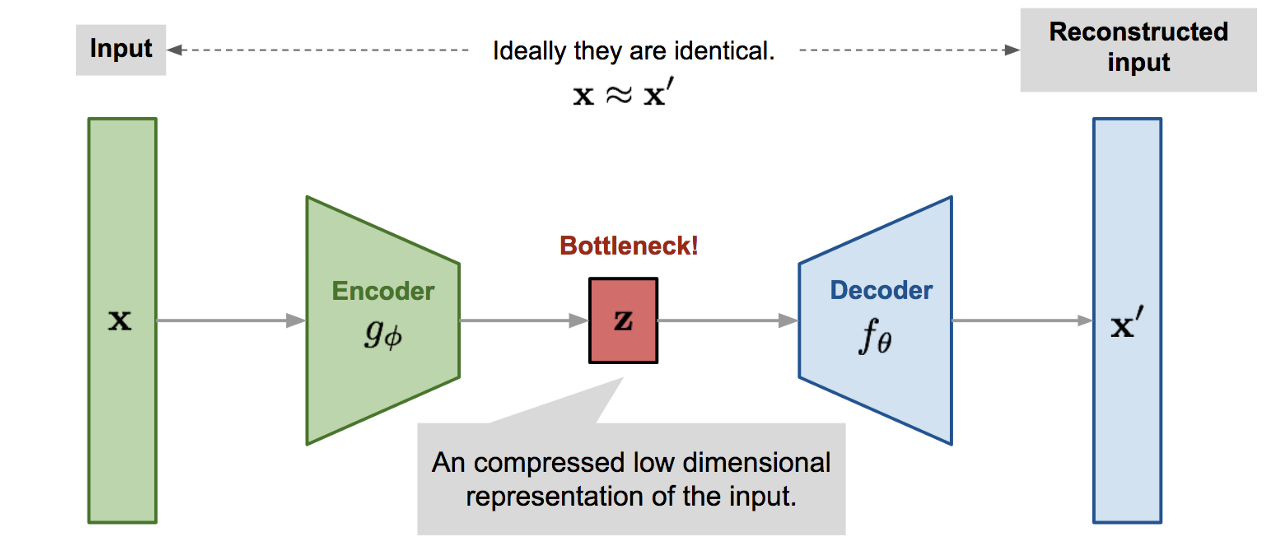

จากภาพ ส่วนปลายด้านที่ติดกับ Input Layer คือ Encoder Function มีหน้าที่แปลง Input Data X เป็น Latent Vector Z ขณะที่ส่วนปลายอีกด้าน คือ Decoder Function ทำหน้าที่แปลง Latent Vector Z กลับเป็น Output Data X'

ซึ่งในระหว่างการ Train Autoencoder กับข้อมูลการให้คะแนนหนังสือของ User, Encoder จะเรียนรู้ที่จะสรุปย่อ Information (Latent Vector Z) จาก Input Data และ Decoder จะเรียนรู้ที่จะแปลง Latent Vector Z กลับเป็น Output Data ที่ปลายอีกด้านของ Model

เราจะใช้ Autoencoder รับข้อมูลการให้คะแนนหนังสือ 7,602 เล่ม ของ User แต่ละคน โดยใช้ Mean Squared Error เป็น Loss Function และใช้ Sigmoid Activate Function เพื่อแปลง Output Data ให้อยู่ในช่วง 0 - 1

###นิยาม Model

1) นิยาม Encoder

In [ ]:
num_input = len(books)

inp = tf.keras.layers.Input((num_input))
e = tf.keras.layers.Dense(10)(inp)
e = tf.keras.layers.BatchNormalization()(e)
e = tf.keras.layers.LeakyReLU()(e)

n_bottleneck = 5
bottleneck = tf.keras.layers.Dense(n_bottleneck)(e)

2) นิยาม Decoder

In [ ]:
d = tf.keras.layers.Dense(10)(bottleneck)
d = tf.keras.layers.BatchNormalization()(d)
d = tf.keras.layers.LeakyReLU()(d)

decoded = tf.keras.layers.Dense(num_input, activation='sigmoid')(d)

ae = tf.keras.models.Model(inp, decoded)
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7602)]            0         
                                                                 
 dense (Dense)               (None, 10)                76030     
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 10)                60        
                                                             

Compile Model

In [ ]:
ae.compile(loss='mse', optimizer='adam')

ทำ Check Point เพื่อ Save Weight ของ Model เฉพาะใน Epoch ที่มี val_loss น้อยที่สุด

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Train Model

In [ ]:
history = ae.fit(x_train, x_train, epochs=300, verbose=1, batch_size=32, validation_data=(x_val, x_val), callbacks = [checkpoint], shuffle= True)

Epoch 1/300
82/86 [===========================>..] - ETA: 0s - loss: 0.2123
Epoch 1: val_loss improved from inf to 0.20452, saving model to model.h5
86/86 [==============================] - 4s 19ms/step - loss: 0.2105 - val_loss: 0.2045
Epoch 2/300
80/86 [==========================>...] - ETA: 0s - loss: 0.1236
Epoch 2: val_loss improved from 0.20452 to 0.12648, saving model to model.h5
86/86 [==============================] - 1s 10ms/step - loss: 0.1210 - val_loss: 0.1265
Epoch 3/300
81/86 [===========================>..] - ETA: 0s - loss: 0.0552
Epoch 3: val_loss improved from 0.12648 to 0.06542, saving model to model.h5
86/86 [==============================] - 1s 10ms/step - loss: 0.0542 - val_loss: 0.0654
Epoch 4/300
83/86 [===========================>..] - ETA: 0s - loss: 0.0250
Epoch 4: val_loss improved from 0.06542 to 0.03428, saving model to model.h5
86/86 [==============================] - 1s 10ms/step - loss: 0.0248 - val_loss: 0.0343
Epoch 5/300
84/86 [=====================

Plot Loss

In [ ]:
h1 = go.Scatter(y=history.history['loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                        name="loss"
                   )
h2 = go.Scatter(y=history.history['val_loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                        name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1)

Load Weight จาก Epoch ที่ val_loss ต่ำที่สุด

In [ ]:
predict_model = load_model(filename)
predict_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7602)]            0         
                                                                 
 dense (Dense)               (None, 10)                76030     
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 10)                60        
                                                             

Predict Model

In [ ]:
print(user_book_matrix.shape)

preds = predict_model(user_book_matrix)

(3426, 7602)


###แปลงผลการ Predict เป็น Table ลงใน SQLite Database

1) แปลงผลการ Predict ของ Model เป็น Dataframe

In [ ]:
preds = preds.numpy()

pred_data = pd.DataFrame(preds)
pred_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7592,7593,7594,7595,7596,7597,7598,7599,7600,7601
0,2.882549e-09,6.681817e-10,2.710473e-09,1.222091e-08,4.200281e-09,8.395243e-10,1.791121e-12,8.730454e-10,3.867977e-06,2.042225e-05,...,1.076032e-08,1.013373e-06,3.572530e-10,1.281713e-07,3.482127e-10,1.167626e-04,5.377010e-08,1.201507e-08,7.087409e-09,1.082391e-07
1,3.641368e-13,1.981899e-15,1.134823e-14,1.169588e-13,7.343215e-14,9.813355e-16,4.451647e-12,3.058276e-15,3.246362e-07,2.614812e-17,...,3.866410e-13,1.679754e-07,8.041818e-16,2.709982e-12,1.182791e-15,4.548135e-06,3.389123e-12,1.042138e-13,3.497242e-14,4.055241e-13
2,4.781873e-03,2.336958e-04,2.762221e-04,1.895722e-04,3.025756e-04,1.559397e-04,5.149360e-04,1.216437e-04,2.948329e-04,3.916111e-03,...,2.478071e-04,5.637519e-04,1.222782e-04,1.131824e-04,2.154129e-04,1.243295e-02,3.093400e-04,1.458674e-04,1.839203e-04,2.508824e-04
3,6.054709e-07,4.992917e-06,4.259766e-06,9.222565e-06,5.819642e-06,1.382744e-05,2.054384e-06,5.330886e-06,2.450510e-02,7.510204e-03,...,3.439234e-05,1.982512e-06,4.466884e-06,1.337467e-04,3.034192e-06,7.913434e-07,5.385761e-05,8.574998e-04,1.281142e-05,1.464095e-04
4,5.324366e-17,7.566172e-19,3.167690e-17,3.380117e-16,5.781374e-17,2.587454e-18,8.130335e-26,1.550726e-18,6.725225e-10,1.663045e-02,...,1.269879e-16,9.462919e-12,3.578304e-19,5.155543e-14,6.346419e-19,8.751552e-08,2.782924e-15,7.427395e-14,1.801581e-16,6.975049e-14


2) แปลงผลลัพธ์จาก Matrix เป็น Table

In [ ]:
pred_data = pred_data.stack().reset_index()
pred_data.head()

,level_0,level_1,0
0,0,0,2.882549e-09
1,0,1,6.681817e-10
2,0,2,2.710473e-09
3,0,3,1.222091e-08
4,0,4,4.200281e-09


3) ตั้งชื่อ Column ใหม่

In [ ]:
pred_data.columns = ['UserID', 'BookTitle', 'BookRating']

print(pred_data.shape)
pred_data.head()

(26044452, 3)


,UserID,BookTitle,BookRating
0,0,0,2.882549e-09
1,0,1,6.681817e-10
2,0,2,2.710473e-09
3,0,3,1.222091e-08
4,0,4,4.200281e-09


4) แปลงข้อมูล User Index เป็น UserID

In [ ]:
pred_data['UserID'] = pred_data['UserID'].map(lambda value: users[value])

pred_data.head()

,UserID,BookTitle,BookRating
0,243,0,2.882549e-09
1,243,1,6.681817e-10
2,243,2,2.710473e-09
3,243,3,1.222091e-08
4,243,4,4.200281e-09


5) แปลงข้อมูล BookTitle Index เป็น BookTitle

In [ ]:
pred_data['BookTitle'] = pred_data['BookTitle'].map(lambda value: books[value])

pred_data.head()

,UserID,BookTitle,BookRating
0,243,'Salem's Lot,2.882549e-09
1,243,01-01-00: The Novel of the Millennium,6.681817e-10
2,243,10 Lb. Penalty,2.710473e-09
3,243,1001 Ways to Be Romantic,1.222091e-08
4,243,101 Dalmatians,4.200281e-09


6) บันทึกข้อมูลลง SQLite Database

บันทึกข้อมูลจำนวนมากกว่า 26 ล้าน Record! ลงใน SQLite Database (ใช้เนื้อที่ของ HDD ประมาณ 2GB)

In [ ]:
pred_data.to_sql("pred_data", connect, if_exists='fail')

26044452

#Query Top 10 Book Rating

1) ค้นหาหนังสือให้แก่ UserID 243 โดยเรียงลำดับคะแนนความชอบตามที่ Model ทำนาย

In [ ]:
%%sql
SELECT *
FROM pred_data
WHERE UserID=243
ORDER BY BookRating DESC
LIMIT 10

 * sqlite:///book_rec.db
Done.


index,UserID,BookTitle,BookRating
2422,243,Harry Potter and the Chamber of Secrets (Book 2),0.9720174074172974
6486,243,The Red Tent (Bestselling Backlist),0.963397204875946
6575,243,The Secret Life of Bees,0.9522117972373962
7393,243,Where the Heart Is (Oprah's Book Club (Paperback)),0.816903829574585
6404,243,The Pilot's Wife : A Novel,0.44109678268432617
6302,243,The Nanny Diaries: A Novel,0.4299628436565399
1623,243,Divine Secrets of the Ya-Ya Sisterhood: A Novel,0.41339918971061707
2679,243,I Know This Much Is True,0.3987140357494354
2426,243,Harry Potter and the Prisoner of Azkaban (Book 3),0.29024869203567505
2428,243,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),0.22176127135753632


2) เปรียบเทียบกับหนังสือที่ UserID 243 เคยให้คะแนนมากที่สุด 10 อันดับ

In [ ]:
%%sql
SELECT *
FROM rating_book
WHERE UserID=243
ORDER BY BookRating DESC
LIMIT 10

 * sqlite:///book_rec.db
Done.


UserID,ISBN,BookRating,BookTitle
243,0060915544,10,The Bean Trees
243,0375400117,10,Memoirs of a Geisha
243,0316601950,9,The Pilot's Wife : A Novel
243,0316776963,9,Me Talk Pretty One Day
243,0425163407,9,Unnatural Exposure
243,0446364800,9,The General's Daughter
243,0553580388,8,The Patient
243,0060977493,7,The God of Small Things
243,0316899984,7,"River, Cross My Heart"
243,0385720106,7,A Map of the World
